<a href="https://colab.research.google.com/github/the-guti/ugrip-energy/blob/main/VPG__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing VPG (Vanilla Policy Gradient) using custom environment

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.distributions import Categorical 
import random

class VPGNet(nn.Module): #Policy network 
    def __init__(self, state_size, action_size):
        super(VPGNet, self).__init__()
        self.input = nn.Linear(state_size, 16)
        self.fc = nn.Linear(16, 16)
        self.output = nn.Linear(16, action_size)

    def forward(self, x): #Returns {action_size} probability values in a tensor
        x = F.relu(self.input(x))
        x = F.relu(self.fc(x))
        x = self.output(x)
        x = F.softmax(x)
        return x


In [2]:
class VPGAgent:
    def __init__(self, state_size, action_size, gamma=0.95, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.states = []
        self.actions = []
        self.rewards = []
        
        self.policy_net = VPGNet(state_size, action_size)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)

    def get_action(self, state): 
        '''
        Returns a tensor with a value ranging from 0 to action_size-1.
        In our case, the action values are interprated as follows:
    
        0: charge_from_solar
        1: charge_from_external
        2: use_battery 
        3: use_external_source 
        '''
        state = torch.FloatTensor(state)
        probs = self.policy_net(state)
        m = Categorical(probs)
        action = m.sample()
        return action

    def store_experience(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def learn(self):
        states = torch.FloatTensor(self.states)
        actions = torch.LongTensor(self.actions)
        discounted_rewards = torch.tensor(self.discount_rewards(self.rewards), dtype=torch.float32)
    
        #Policy loss
        log_probs = torch.log(self.policy_net(states)).gather(1, actions.unsqueeze(1))
        policy_loss = torch.mean(-log_probs * discounted_rewards)

        #Optimizing the network
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()


        self.states = []
        self.actions = []
        self.rewards = []
    def discount_rewards(self, rewards):
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        discounted_rewards = torch.zeros_like(rewards_tensor)
        running_sum = 0
        for t in reversed(range(len(rewards))):
            running_sum = running_sum * self.gamma + rewards_tensor[t]
            discounted_rewards[t] = running_sum
        return discounted_rewards.detach().numpy().tolist()




In [3]:
class Environment:
    def __init__(self, dataset):
        self.state_size = 4  # Battery state of charge, solar power generation, electricity consumption, price of electricity
        self.action_size = 4  # Charge from solar, charge from external source, use energy from battery, use energy from external source
        self.batteryCharge = 0
        self.index = 0
        self.data = dataset
    def get_state(self, index):
        battery_state_of_charge = self.batteryCharge
        solar_energy = self.data.loc[index, 'solar']
        electricity_demand = self.data.loc[index, 'load']
        price = self.data.loc[index, 'price']
        state = [battery_state_of_charge, solar_energy, electricity_demand, price]       
        return state

    def step(self, action):
        done = self.index >= len(self.data)-1
        next_state = self.get_state(self.index) if self.index < len(self.data)else self.get_state(len(self.data)-1)
        reward = 0

        battery_state_of_charge = next_state[0]
        solar_power_generation = next_state[1]
        electricity_demand = next_state[2]
        price_of_external_electricity = next_state[3]

        charge_from_solar = action.item() == 0
        charge_from_external = action.item() == 1
        use_battery = action.item() == 2
        use_external_source = action.item() == 3

        # Calculating the reward based on the action taken and the next state
        if charge_from_solar:
            # When charging from solar, the agent gets positive reward for using solar power
            reward += solar_power_generation * price_of_external_electricity
        if charge_from_external:
            # When charging from external source, the agent gets reward based on the price of external electricity
            reward -= electricity_demand * price_of_external_electricity
        if use_battery:
            # When using energy from battery, the agent gets reward based on the avoided cost of external electricity
            reward += price_of_external_electricity * min(battery_state_of_charge, electricity_demand)
        if use_external_source:
            # When using energy from external source, reward based on the cost of external electricity
            reward -= electricity_demand * price_of_external_electricity
        
        # Updating the battery based on the action taken
        if charge_from_solar:
            self.batteryCharge = min(self.batteryCharge + solar_power_generation, 100)  
        if charge_from_external:
            self.batteryCharge = min(self.batteryCharge + electricity_demand, 100)
        if use_battery:
            self.batteryCharge = max(self.batteryCharge - electricity_demand, 0)
        
        self.index +=1
        return next_state, reward, done

    def reset(self):
        self.index = 0
        self.batteryCharge=0

**Generating the Dataset**

In [4]:
random.seed(42)

data = []

for day in range( 1):
    for hour in range( 24):
        time = hour
        
        solar_energy = 0.0
        demand = 0.0
        price = 0.0

        if hour >= 5 and hour <= 8:
            demand = random.uniform(5, 10)
            price = random.uniform(5,10 )
        elif hour >= 17 and hour <= 21:
            demand = random.uniform(5, 10)
            price = random.uniform(5, 10)
        else:
            demand = random.uniform(0, 5)
            price = random.uniform(0, 5)
            
        if hour < 9:
            solar_energy = random.uniform(0, 5)
        elif hour >= 9 and hour < 15:
            solar_energy = random.uniform(5, 10)
        elif hour >= 15 and hour < 17:
            solar_energy = random.uniform(0, 3)
        
        data.append([time, solar_energy, demand, price])

df = pd.DataFrame(data, columns=['Time', 'solar', 'load', 'price'])
df.to_csv('./energy.csv')


In [5]:
df.head()

,Time,solar,load,price
0,0,1.375147,3.197134,0.125054
1,1,3.383497,1.116054,3.682356
2,2,2.109609,4.460898,0.434694
3,3,2.526776,0.148986,1.093190
4,4,3.249422,0.132680,0.994188


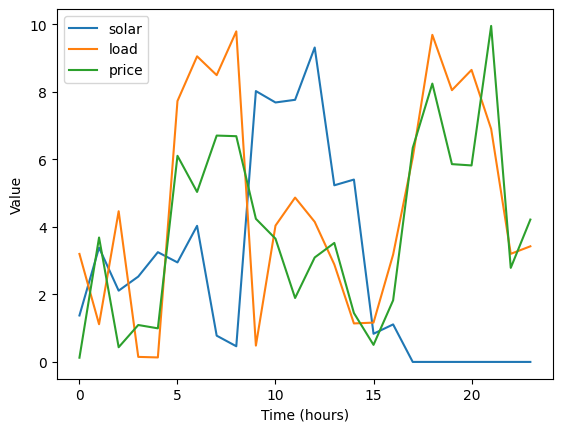

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
variable_columns = df.columns.tolist()
fig, ax = plt.subplots()
for column in variable_columns:
    if column != 'Time':
        ax.plot(df[column], label=column)
ax.set_xlabel('Time (hours)')
ax.set_ylabel("Value")
ax.legend()

plt.show()

In [7]:
dataset = pd.read_csv('energy.csv')
del dataset['Unnamed: 0']
dataset.head()


,Time,solar,load,price
0,0,1.375147,3.197134,0.125054
1,1,3.383497,1.116054,3.682356
2,2,2.109609,4.460898,0.434694
3,3,2.526776,0.148986,1.093190
4,4,3.249422,0.132680,0.994188


**Training and Testing**

In [9]:
env = Environment(dataset)
state_size = env.state_size
action_size = env.action_size
agent = VPGAgent(state_size, action_size)


In [19]:
num_episodes = 1000

for episode in range(num_episodes):
    env.reset()
    state = env.get_state(0)
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.store_experience(state, action, reward)
        state = next_state
    agent.learn()


<ipython-input-1-2324e6caba4f>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [20]:
num_eval_episodes = 100
total_rewards = []

for _ in range(num_eval_episodes):
    env.reset()
    state = env.get_state(0)
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state

    total_rewards.append(total_reward)

average_reward = np.mean(total_rewards)
print("Average reward:", average_reward)


<ipython-input-1-2324e6caba4f>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Average reward: 465.51643968689825


**The distribution of the total rewards**

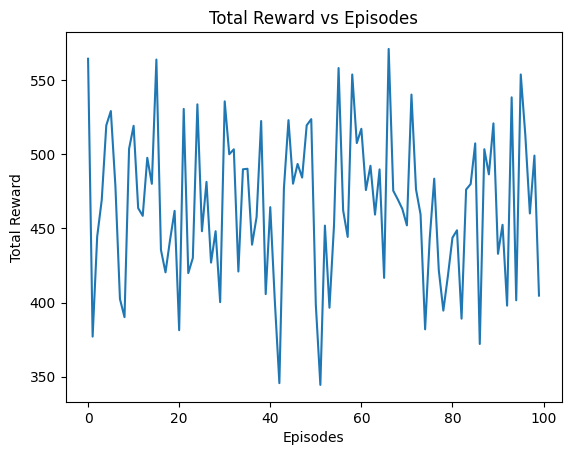

In [21]:
index = range(len(total_rewards))
plt.plot(index, total_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title("Total Reward vs Episodes")
plt.show()


### Distribution of Variables

In [22]:
num_eval_episodes = 1
Data = []

for _ in range(num_eval_episodes):
    EpisodeData = []
    env.reset()
    state = env.get_state(0)
    done = False
    total_reward = 0
    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        stateCopy = state.copy()
        stateCopy.append(action.item())
        stateCopy.append(reward)
        EpisodeData.append(stateCopy)
        state = next_state
    total_rewards.append(total_reward)
    Data.append(EpisodeData)



<ipython-input-1-2324e6caba4f>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


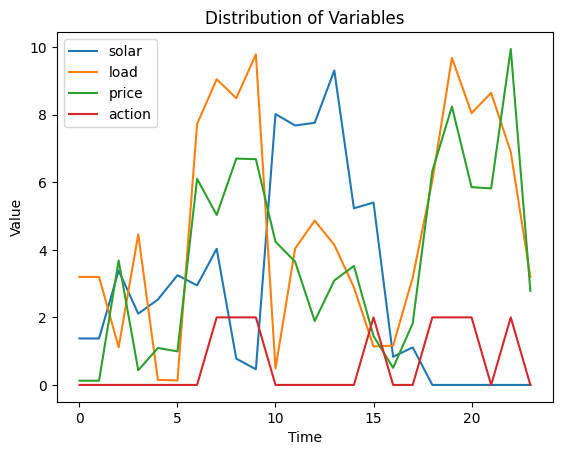

In [23]:

df2 = pd.DataFrame(Data[0], columns=['Battery percent', 'solar', 'load', 'price', 'action', "reward"])
df2.head()
fig, ax = plt.subplots()
for column in df2.columns:
    if column != 'Battery percent' and column != 'reward':
        ax.plot(df2[column], label=column)

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Distribution of Variables')

ax.legend()

plt.show()

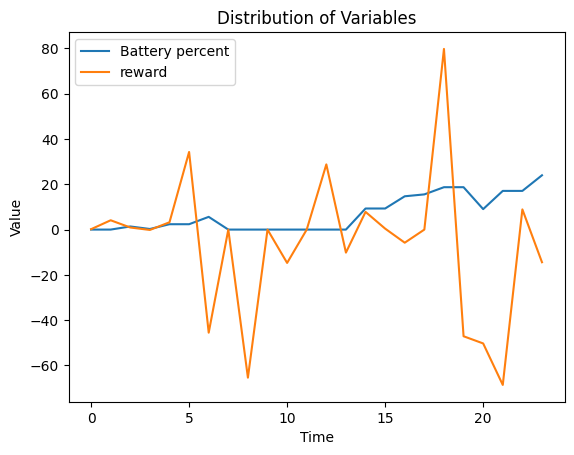

In [18]:
fig, ax = plt.subplots()
for column in df2.columns:
    if column == 'Battery percent' or column == 'reward':
        ax.plot(df2[column], label=column)

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Distribution of Variables')

ax.legend()

plt.show()